In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [2]:
train_set = pd.read_csv(r"/tmp/Restaurant_Reviews(NLP)(train).csv",encoding='utf-8')
test_set = pd.read_csv(r"/tmp/Restaurant_Reviews(NLP)(test).csv",encoding='utf-8')

In [3]:
train_set.head(10)

,Review,Liked
0,Wow... Loved this place.,Good
1,Crust is not good.,Bad
2,Not tasty and the texture was just nasty.,Bad
3,Stopped by during the late May bank holiday of...,Good
4,The selection on the menu was great and so wer...,Good
5,Now I am getting angry and I want my damn pho.,Bad
6,Honeslty it didn't taste THAT fresh.),Bad
7,The potatoes were like rubber and you could te...,Bad
8,The fries were great too.,Good
9,A great touch.,Good


In [4]:
full_data = train_set.append(test_set)
full_data

,Review,Liked
0,Wow... Loved this place.,Good
1,Crust is not good.,Bad
2,Not tasty and the texture was just nasty.,Bad
3,Stopped by during the late May bank holiday of...,Good
4,The selection on the menu was great and so wer...,Good
...,...,...
196,If you stay in Vegas you must get breakfast he...,Good
197,I want to first say our server was great and w...,Good
198,The pizza selections are good.,Good
199,"I had strawberry tea, which was good.",Good


In [5]:
X_train = train_set['Review']
X_test = test_set['Review']
y_train = train_set['Liked']
y_test = test_set['Liked']

print(full_data.Liked.value_counts())

Good    500
Bad     500
Name: Liked, dtype: int64


In [6]:
X_train[12],y_train[12]

('The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.',
 'Bad')

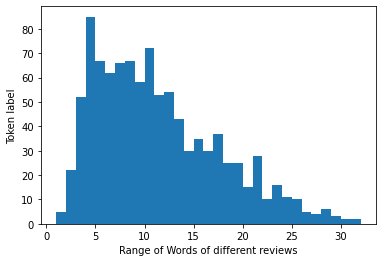

In [7]:
lengths = [len(t.split(' ')) for t in full_data['Review']]
plt.hist(lengths, bins = len(set(lengths)))
plt.xlabel('Range of Words of different reviews') 
plt.ylabel('Token label')
plt.show()  

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_data['Review'])

Train_sequence = tokenizer.texts_to_sequences(X_train)
Test_sequence = tokenizer.texts_to_sequences(X_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Total Number of different types of words: {}'.format(len(index_of_words)))

Total Number of different types of words: 2068


In [9]:
print(X_train[12])
print(tokenizer.texts_to_sequences([X_train[12]]))

The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.
[[1, 590, 23, 58, 434, 66, 26, 52, 34, 66, 3, 23, 6, 106, 9, 152, 591, 55, 122, 909, 233]]


In [10]:
def get_sequences(tokenizer , review):
    sequences = tokenizer.texts_to_sequences(review)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=30)
    return padded
padded_train_seq = get_sequences(tokenizer , X_train)
padded_train_seq[12]

array([  1, 590,  23,  58, 434,  66,  26,  52,  34,  66,   3,  23,   6,
       106,   9, 152, 591,  55, 122, 909, 233,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

{'Bad', 'Good'}


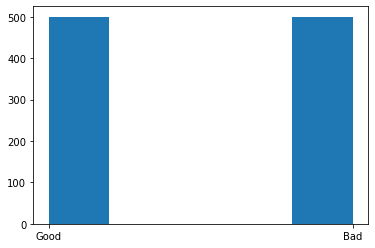

In [11]:
classes = set(y_train)
print(classes)
plt.hist(full_data['Liked'],bins=5)
plt.show()

In [12]:
classes_to_index = dict((c,i) for i , c in enumerate(classes))
index_to_classes = dict((v,k) for k , v in classes_to_index.items())
classes_to_index

{'Bad': 0, 'Good': 1}

In [13]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])
train_labels = names_to_ids(y_train)
print(train_labels[12])

0


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=30),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 175,762
Trainable params: 175,762
Non-trainable params: 0
_________________________________________________________________


In [15]:
val_sequences = get_sequences(tokenizer, X_test)
y_test = names_to_ids(y_test)
X_test[200], y_test[200]

('Highly unprofessional and rude to a loyal patron!', 0)

In [16]:
history = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_sequences, y_test),
    epochs=20,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
25/25 [==============================] - 6s 72ms/step - loss: 0.6859 - accuracy: 0.5557 - val_loss: 0.7708 - val_accuracy: 0.2438
Epoch 2/20
25/25 [==============================] - 0s 20ms/step - loss: 0.6745 - accuracy: 0.5645 - val_loss: 0.7905 - val_accuracy: 0.2488
Epoch 3/20
25/25 [==============================] - 0s 19ms/step - loss: 0.6037 - accuracy: 0.6596 - val_loss: 0.5623 - val_accuracy: 0.7811
Epoch 4/20
25/25 [==============================] - 0s 18ms/step - loss: 0.3304 - accuracy: 0.8611 - val_loss: 0.6986 - val_accuracy: 0.7065
Epoch 5/20
25/25 [==============================] - 0s 19ms/step - loss: 0.1379 - accuracy: 0.9562 - val_loss: 0.6997 - val_accuracy: 0.7114


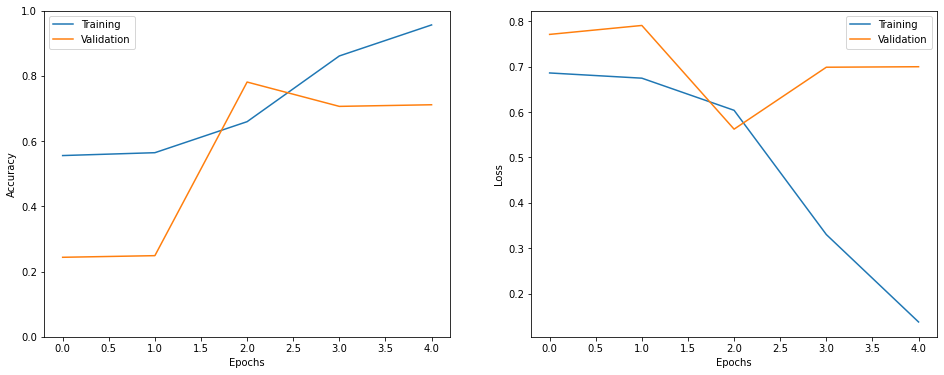

In [17]:
epochs_trained = len(history.history['loss'])
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(range(0, epochs_trained), history.history.get('accuracy'), label='Training')
plt.plot(range(0, epochs_trained), history.history.get('val_accuracy'), label='Validation')
plt.ylim([0., 1.])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0, epochs_trained), history.history.get('loss'), label='Training')
plt.plot(range(0, epochs_trained), history.history.get('val_loss'), label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
message = ["Ice cream makes me feel mouth watering"]

new_sequence = tokenizer.texts_to_sequences(message)
new_pad = pad_sequences(new_sequence, maxlen=30)
prediction = model.predict(new_pad)

print('Message: ' + str(message))
print('Predicted Emotion:', index_to_classes[np.argmax(prediction[0])])
print(prediction[0])

1/1 [==============================] - 0s 26ms/step
Message: ['Ice cream makes me feel mouth watering']
Predicted Emotion: Good
[0.31110597 0.76339823]
